# 09 Sentinel-1 backscatter profile for reference image used in flood analysis

## Quick link
 
* [Objective](#objective)
* [Test Site](#test-site)
* [Context](#context)
* [Applicability](#applicability)
* [Data](#data)
* [Workflow](#workflow)
 * [Step 0: Data preparation](#subset)
 * [Step 1: Pre-processing - Calibration](#calibration)
 * [Step 2: Pre-processing - Speckle filtering](#speckle)
 * [Step 3: Pre-processing - Linear to dB](#lineartodb)
 * [Step 4: Distribution analysis and probability density function fitting](#distribution)
 * [Step 5: Anomaly index 1 - Backscattering spread](#anomaly1)
 * [Step 6: Anomaly index 2 - Backscattering statistical distribution distance](#anomaly2)
 * [Step 7: Anomaly index 3 - Final score](#anomaly3)
* [Strengths and Limitations](#strengths-limitations) 
* [License](#license)

## <a name="objective">Objective 

The objective of this practice is to determine the backscatter profiles of a stack of Sentinel-1 GRD datasets and rapidly and reliably extract the most adequate reference image from it.

## <a name="testsite">Methodology

We apply here the principles descrbed by [Hostache et al., 2012, Change detection approaches for flood extent mapping: How to select the most adequate reference image from online archives?](https://www.researchgate.net/publication/230627460_Change_detection_approaches_for_flood_extent_mapping_How_to_select_the_most_adequate_reference_image_from_online_archives)


## <a name="testsite">Test Site

Mopti (Mali)

## <a name="context">Context

The practice was applied to the flood event in Mopti in July 2016.

## <a name="applicability">Applicability

This practice can be applied globally. It will be applied as input for a correlated search in the catalog allowing to identify rapidly a reference image for a flooding image.


## <a name="data">Data

SENTINEL data products are made available systematically and free of charge to all data users including the general public, scientific and commercial users. Radar data will be delivered within an hour of reception for Near Real-Time (NRT) emergency response, within three hours for NRT priority areas and within 24 hours for systematically archived data.

All data products are distributed in the SENTINEL Standard Archive Format for Europe (SAFE) format.

Data products are available in single polarisation (VV or HH) for Wave mode and dual polarisation (VV+VH or HH+HV) and single polarisation (HH or VV) for SM, IW and EW modes.

Level-1 Ground Range Detected (GRD) products consist of focused SAR data that has been detected, multi-looked and projected to ground range using an Earth ellipsoid model. Phase information is lost. The resulting product has approximately square resolution pixels and square pixel spacing with reduced speckle at the cost of reduced geometric resolution.

GRD products can be in one of three resolutions:

* Full Resolution (FR)
* High Resolution (HR)
* Medium Resolution (MR).

The resolution is dependent upon the amount of multi-looking performed. Level-1 GRD products are available in MR and HR for IW and EW modes, MR for WV mode and MR, HR and FR for SM mode.

## <a name="data">Let's get the work done

Define the product to process:

In [1]:
s1paths = ( "S1A_IW_GRDH_1SDV_20151226T182813_20151226T182838_009217_00D48F_5D5F", "S1A_IW_GRDH_1SDV_20160424T182813_20160424T182838_010967_010769_AA98", "S1A_IW_GRDH_1SDV_20160518T182817_20160518T182842_011317_011291_936E", "S1A_IW_GRDH_1SDV_20160611T182819_20160611T182844_011667_011DC0_391B", "S1A_IW_GRDH_1SDV_20160705T182820_20160705T182845_012017_0128E1_D4EE", "S1A_IW_GRDH_1SDV_20160729T182822_20160729T182847_012367_013456_E8BF", "S1A_IW_GRDH_1SDV_20160822T182823_20160822T182848_012717_013FFE_90AF", "S1A_IW_GRDH_1SDV_20160915T182824_20160915T182849_013067_014B77_1FCD" ) 

In [2]:
from snappy import jpy
from snappy import ProductIO

s1meta = "manifest.safe"

products = []

for s1path in s1paths:

    s1prd= "/workspace/data/%s/%s.SAFE/%s" % (s1path, s1path, s1meta)
    reader = ProductIO.getProductReader("SENTINEL-1")
    product = reader.readProductNodes(s1prd, None)
    products.append(product)

Extract information about the Sentinel-1 GRD products:

In [3]:
for product in products:

    width = product.getSceneRasterWidth()
    height = product.getSceneRasterHeight()
    name = product.getName()
    band_names = product.getBandNames()
    print("Product: %s, %d x %d pixels" % (name, width, height))
    print("Bands:   %s" % (list(band_names)))

Product: S1A_IW_GRDH_1SDV_20151226T182813_20151226T182838_009217_00D48F_5D5F, 25242 x 16791 pixels
Bands:   ['Amplitude_VH', 'Intensity_VH', 'Amplitude_VV', 'Intensity_VV']
Product: S1A_IW_GRDH_1SDV_20160424T182813_20160424T182838_010967_010769_AA98, 25180 x 16805 pixels
Bands:   ['Amplitude_VH', 'Intensity_VH', 'Amplitude_VV', 'Intensity_VV']
Product: S1A_IW_GRDH_1SDV_20160518T182817_20160518T182842_011317_011291_936E, 25184 x 16804 pixels
Bands:   ['Amplitude_VH', 'Intensity_VH', 'Amplitude_VV', 'Intensity_VV']
Product: S1A_IW_GRDH_1SDV_20160611T182819_20160611T182844_011667_011DC0_391B, 25184 x 16804 pixels
Bands:   ['Amplitude_VH', 'Intensity_VH', 'Amplitude_VV', 'Intensity_VV']
Product: S1A_IW_GRDH_1SDV_20160705T182820_20160705T182845_012017_0128E1_D4EE, 25183 x 16805 pixels
Bands:   ['Amplitude_VH', 'Intensity_VH', 'Amplitude_VV', 'Intensity_VV']
Product: S1A_IW_GRDH_1SDV_20160729T182822_20160729T182847_012367_013456_E8BF, 25184 x 16804 pixels
Bands:   ['Amplitude_VH', 'Intensity

## <a name="workflow">Workflow

* Step 0: Data preparation - Subset
* Step 1: Pre-processing - Calibration
* Step 2: Pre-processing - Speckle filtering
* Step 3: Pre-processing - Linear to dB
* Step 4: Distribution analysis and probability density function fitting
* Step 5: Anomaly index 1 - Backscattering spread
* Step 6: Anomaly index 2 - Backscattering statistical distribution distance
* Step 7: Anomaly index 3 - Final score


### <a name="subset">Step 0: Data preparation - Subset

We extract a subset of the Sentinel-1 GRD products by specify a rectangle:

In [4]:
from snappy import GPF
from snappy import HashMap
import snappy

WKTReader = snappy.jpy.get_type('com.vividsolutions.jts.io.WKTReader')

geom = WKTReader().read('POLYGON((-4.51 14.69,-4.477 14.227,-4.076 14.243,-4.054 14.642,-4.51 14.69))');


HashMap = jpy.get_type('java.util.HashMap')    
GPF.getDefaultInstance().getOperatorSpiRegistry().loadOperatorSpis()

parameters = HashMap()
parameters.put('copyMetadata', True)
parameters.put('geoRegion', geom)

subsets = []

for product in products:

    subset = GPF.createProduct('Subset', parameters, product)
    subsets.append(subset)

### <a name="calibration">Step 1: Pre-processing - Calibration

The objective of SAR calibration is to provide imagery in which the pixel values can be directly related to the radar backscatter of the scene. Though uncalibrated SAR imagery is sufficient for qualitative use, calibrated SAR images are essential to quantitative use of SAR data.

Typical SAR data processing, which produces level 1 images, does not include radiometric corrections and significant radiometric bias remains. Therefore, it is necessary to apply the radiometric correction to SAR images so that the pixel values of the SAR images truly represent the radar backscatter of the reflecting surface. The radiometric correction is also necessary for the comparison of SAR images acquired with different sensors, or acquired from the same sensor but at different times, in different modes, or processed by different processors.

In [5]:
parameters = HashMap()

parameters.put('auxFile', 'Latest Auxiliary File')
parameters.put('outputSigmaBand', True)
parameters.put('selectedPolarisations', 'VV')

calibrates = []

for subset in subsets:

    calibrate = GPF.createProduct('Calibration', parameters, subset)
    calibrates.append(calibrate)

### <a name="speckle">Step 2: Pre-processing - Speckle filtering

SAR images have inherent salt and pepper like texturing called speckles which degrade the quality of the image and make interpretation of features more difficult. Speckles are caused by random constructive and destructive interference of the de-phased but coherent return waves scattered by the elementary scatters within each resolution cell. Speckle noise reduction can be applied either by spatial filtering or multilook processing. 

In [6]:
parameters = HashMap()

parameters.put('filter', 'Lee')
parameters.put('filterSizeX', 7)
parameters.put('filterSizeY', 7)
parameters.put('dampingFactor', 2)
parameters.put('edgeThreshold', 5000.0)
parameters.put('estimateENL', True)
parameters.put('enl', 1.0)

speckles = []

for calibrate in calibrates:

    speckle = GPF.createProduct('Speckle-Filter', parameters, calibrate)
    speckles.append(speckle)

###  <a name="lineartodb">Step 3: Pre-processing - Linear to dB

In [7]:
parameters = HashMap()

lineartodbs= []
dates = [];

for speckle in speckles : 

    lineartodb = GPF.createProduct('linearToFromdB', parameters, speckle)
    lineartodbs.append(lineartodb)
    name = lineartodb.getName()
    timestamp = name.split("_")[5] 
    date = timestamp[:8]
    dates.append(date)

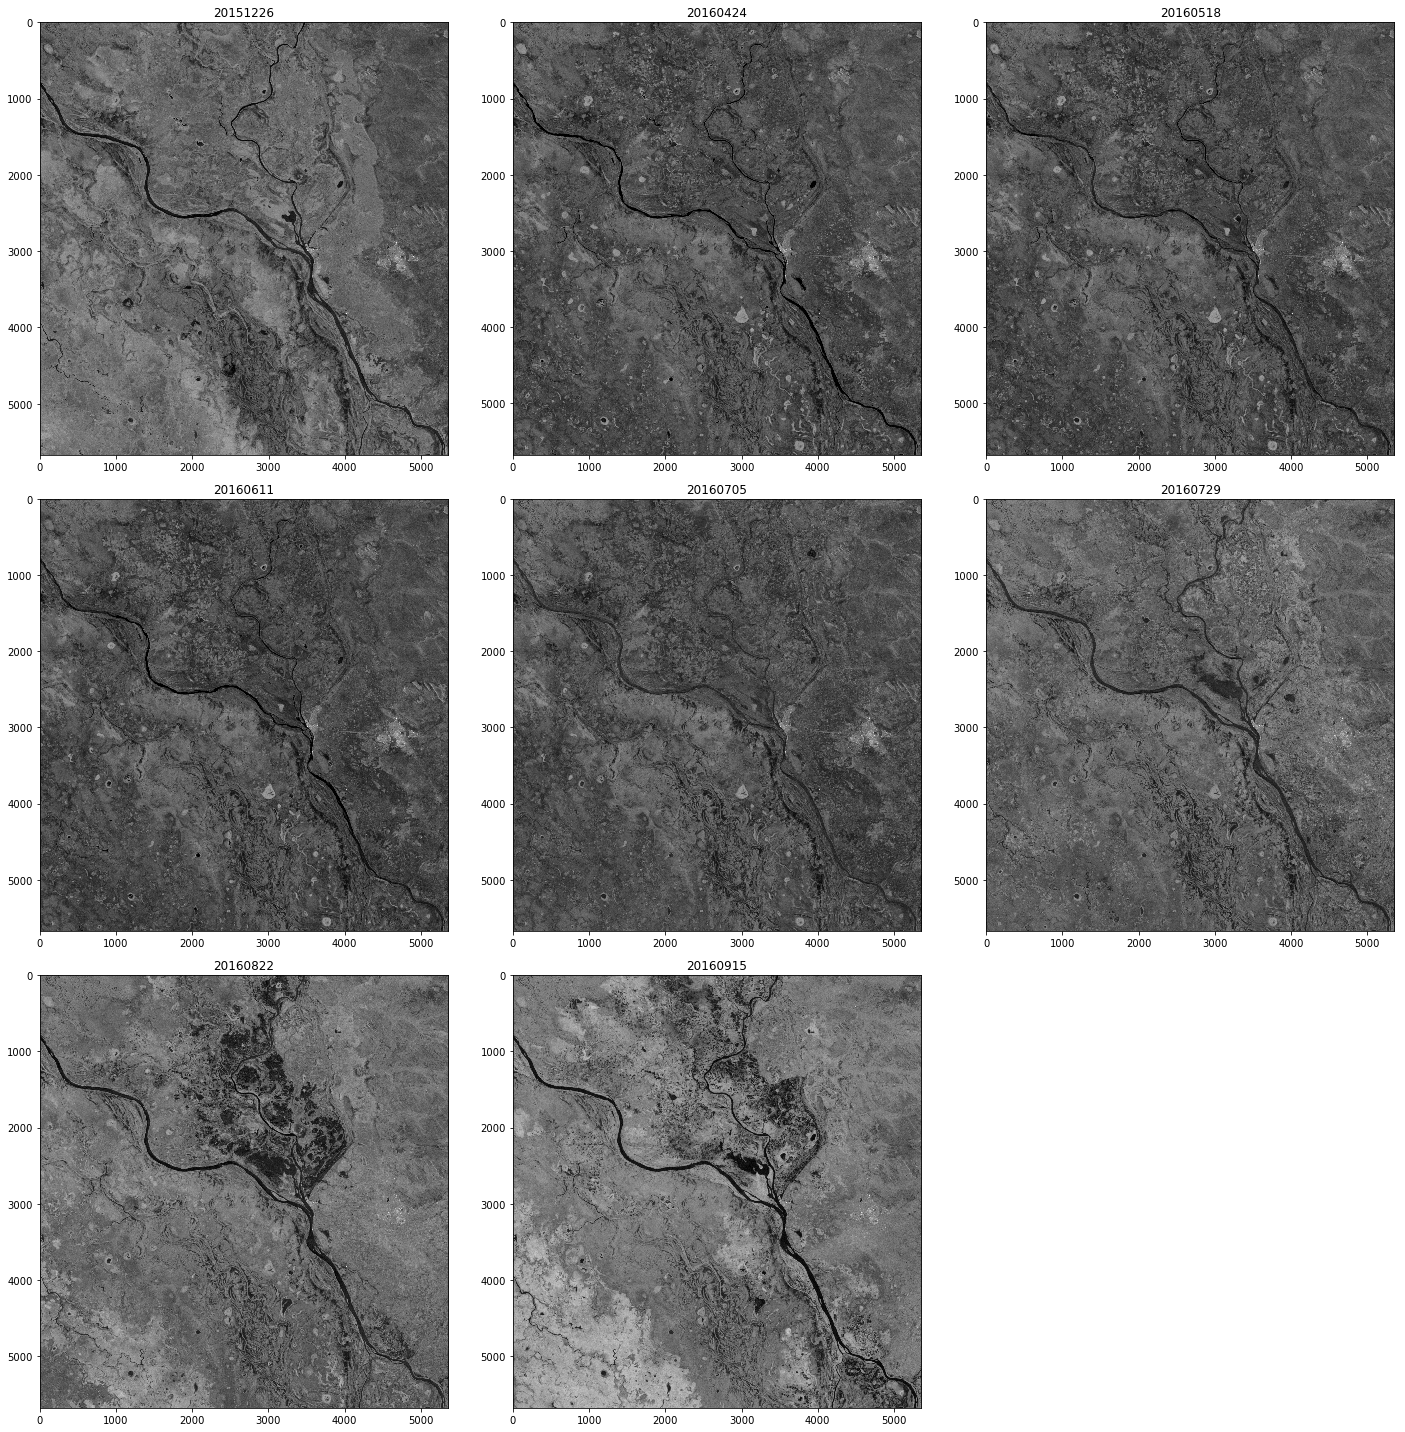

27130

In [8]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import gc 

%matplotlib inline

def plotBand(product, band, vmin, vmax):
     
    band = product.getBand(band)

    w = band.getRasterWidth()
    h = band.getRasterHeight()

    band_data = np.zeros(w * h, np.float32)
    band.readPixels(0, 0, w, h, band_data)

    band_data.shape = h, w

    imgplot = plt.imshow(band_data, cmap=plt.cm.binary_r, vmin=vmin, vmax=vmax)

    
    return imgplot 


fig = plt.figure(figsize=(20,20))
i = 1

for lineartodb in lineartodbs :
    
        a=fig.add_subplot(330+i)
        imgplot = plotBand(lineartodb, 'Sigma0_VV_db', -25, 5)
        name = lineartodb.getName()
        timestamp = name.split("_")[5] 
        date = timestamp[:8]
        a.set_title(date)
        i = i+1
    
plt.tight_layout()
fig = plt.gcf()
plt.show()

fig.clf()
plt.close()
gc.collect()

### <a name="distribution">Step 4: Distribution analysis and probability density function fitting

To determine the backscatering profile of each image sample, the backscaterring vales distribution in the image must be analyzed and expressed with a probability distribution function.
In this processing step, we use a normal distribution to fit our values. We then save the mean and standard deviation values.

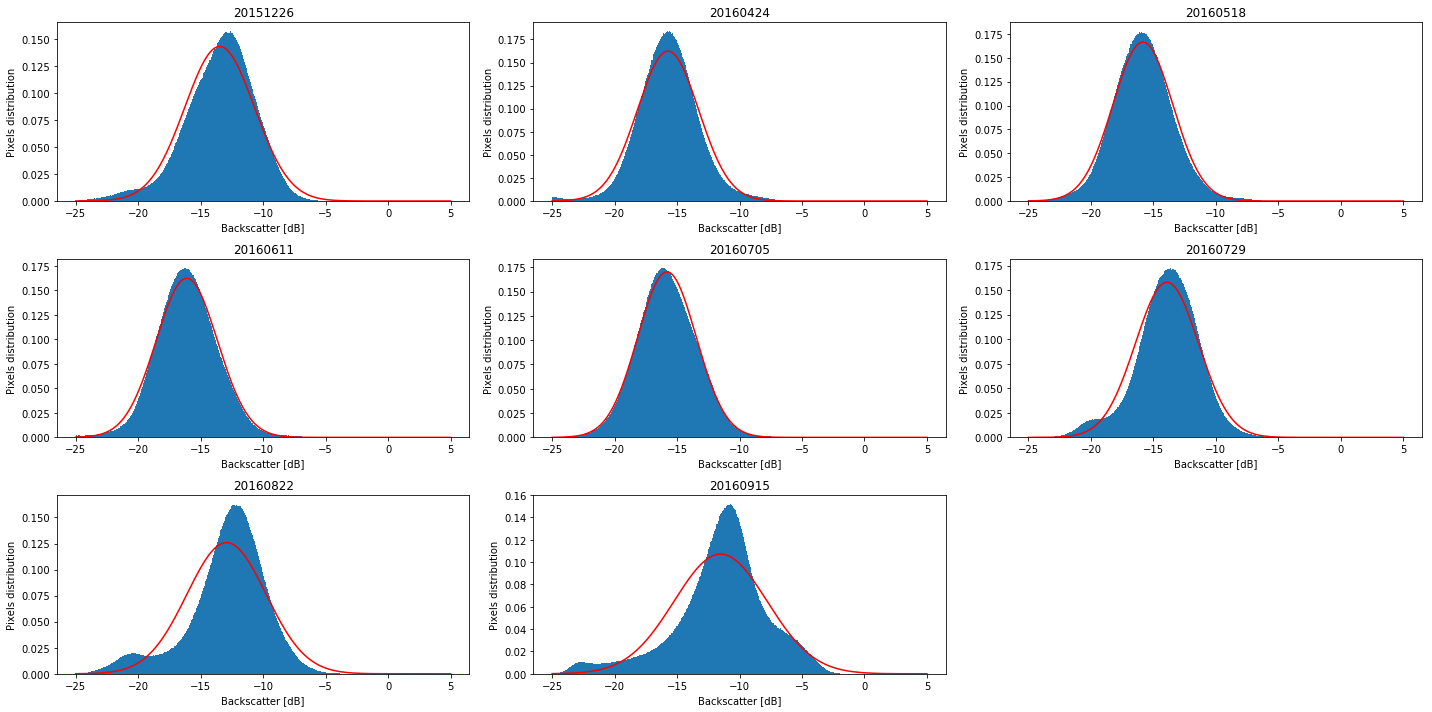

28606

In [9]:
import math
from scipy import stats 

pdf_params = []
lnspc = np.linspace(-25, 5, 2048)

%matplotlib inline

def plotHistdB(lineartodb, band):

    band = lineartodb.getBand(band)

    w = band.getRasterWidth()
    h = band.getRasterHeight()

    band_data = np.zeros(w * h, np.float32)
    band.readPixels(0, 0, w, h, band_data)
    band_data.shape = h * w

    ser = np.asarray(band_data, dtype='float')
    
    m, s = stats.norm.fit(ser) # get mean and standard deviation  
    pdf_params.append([m,s])
    p5 = np.percentile(ser, 5) # return 5th percentile.
    p95 = np.percentile(ser, 95) # return 95th percentile.
    index1 = p95 - p5 # anomaly index 1
    index1s.append(index1)
    
    hist = plt.hist(ser, bins=2048, range=[-25, 5], normed=True)
    pdf_g = stats.norm.pdf(lnspc, m, s) # now get theoretical values in our interval
    pdf = plt.plot(lnspc, pdf_g, label="Norm", c='r') # plot it
    plt.xlabel('Backscatter [dB]')
    plt.ylabel('Pixels distribution')
    
    return hist

index1s = []
fig = plt.figure(figsize=(20,10))
i = 1

for lineartodb in lineartodbs :
    
        a=fig.add_subplot(330+i)
        a.patch.set_alpha(0.7)
        plotHistdB(lineartodb, 'Sigma0_VV_db')
        a.set_title(dates[i-1])
        i = i+1

    
plt.tight_layout()
fig = plt.gcf()
plt.show()
fig.clf()
plt.close()
gc.collect()

### <a name="anomaly1">Step 5: Anomaly index 1 - Backscattering spread

A flood image contains an exceptionally high number of pixels with very low backscatter values. Moreover, in the event of a flood, soils are in general wet and often close to saturation. 
Therefore, a first anomaly index1 should express an image’s spread in the distribution of backscattering values. There is a high likelihood that images exhibiting an irregularly large spread are affected by flooding. The proposed index expresses the distance between the 5% and 95% percentiles inferred from the image histogram. The 5% (resp. 95%) percentile is the backscatter value below which 5% (resp. 95%) of the observations are to be found.

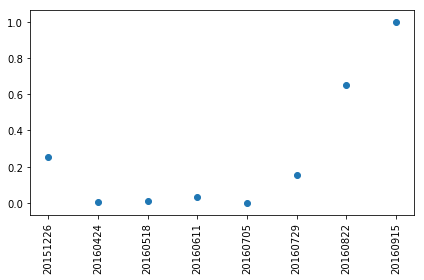

3844

In [10]:
datespc = np.linspace(1, len(dates), len(dates))

index1normalized = (index1s-min(index1s))/(max(index1s)-min(index1s))
plt.scatter(datespc, index1normalized)
plt.xticks(datespc, dates, rotation='vertical')

plt.tight_layout()
fig = plt.gcf()
plt.show()
fig.clf()
plt.close()
gc.collect()

### <a name="anomaly2">Step 6: Anomaly index 2 - Backscattering statistical distribution distance

A second anomaly index2 evaluates the degree to which the backscatter distribution inferred from one image reflects the backscattering behaviour inferred from the full sample. The main idea here is that a reference image for flood detection is required to have a statistical distribution of backscatter values that closely follows the median distribution inferred from a representative sample of candidate images. Anomaly index2 quantifies the distance between the backscatter statistical distribution of a candidate image and the median backscatter statistical distribution over the sample of candidates

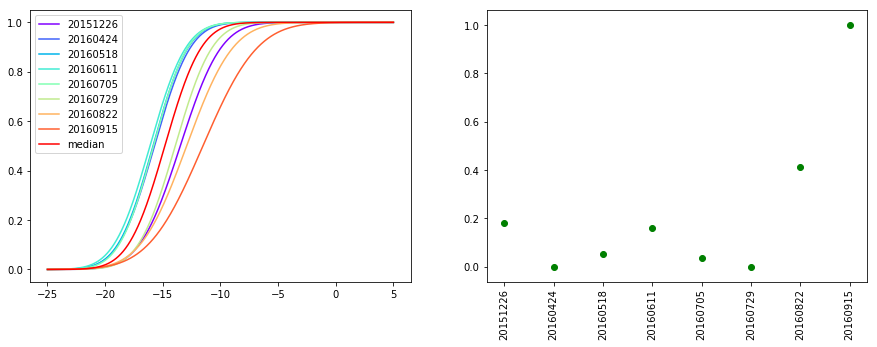

In [11]:
from matplotlib.pyplot import cm 



fig = plt.figure(figsize=(15,5))
color=iter(cm.rainbow(np.linspace(0,1,len(lineartodbs)+1)))
i = 1
arr = np.array(pdf_params)
median = np.median(arr, axis=0)
a=fig.add_subplot(121)
a.patch.set_alpha(0.7)

index2s = []

# Cumulative distributions:
for lineartodb in lineartodbs :


        lnspc = np.linspace(-25, 5, 2048)

        cdf_g = stats.norm.cdf(lnspc, pdf_params[i-1][0], pdf_params[i-1][1])

        #sorted_ser = np.sort(ser)  # Or data.sort(), if data can be modified

        c=next(color)
        cdf = plt.plot(lnspc, cdf_g, label=dates[i-1], c=c) # plot it
        #plt.step(sorted_ser, np.arange(sorted_ser.size), c=c)  # From 0 to the number of data points-1
        #plt.step(sorted_ser[::-1], np.arange(sorted_ser.size))  # From the number of data points-1 to 0

        index2 = math.fabs((median[0]-pdf_params[i-1][0]))
        index2s.append(index2)

        i = i +1


cdf_g = stats.norm.cdf(lnspc, median[0], median[1])
c=next(color)
cdf = plt.plot(lnspc, cdf_g, label="median", c=c)
plt.legend()

a = fig.add_subplot(122)

index2sa = np.asarray(index2s)
index2normalized = (index2sa-min(index2sa))/(max(index2sa)-min(index2sa))
plt.scatter(datespc, index2normalized, c='g')
plt.xticks(datespc, dates, rotation='vertical')

plt.show()

### <a name="anomaly3">Step 7: Anomaly index 3 - Final score

A compromise solution would be to identify the best reference image within the candidate list by combining the anomaly indexes 1 and 2.
While it is helpful to first consider the two anomaly indexes separately, the best reference image for flood mapping applications may arguably be the candidate image having the lowest index3 value. A value close to 0 is assigned to an image that is comparatively dry and representative for an area’s normal backscattering behaviour.

/opt/anaconda/lib/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


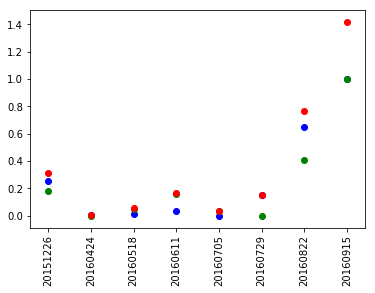

In [12]:
index3 = np.sqrt(np.power(index1normalized,2)+np.power(index2normalized,2))
index3normalized = (index3-min(index3))/(max(index3)-min(index3))

plt.scatter(datespc, index1normalized, c='b')
plt.scatter(datespc, index2normalized, c='g')
plt.scatter(datespc, index3, c='r')
plt.xticks(datespc, dates, rotation='vertical')

plt.legend()
plt.show()

## <a name="license">License

This work is licenced under a [Attribution-ShareAlike 4.0 International License (CC BY-SA 4.0)](http://creativecommons.org/licenses/by-sa/4.0/) 

YOU ARE FREE TO:

* Share - copy and redistribute the material in any medium or format.
* Adapt - remix, transform, and built upon the material for any purpose, even commercially.

UNDER THE FOLLOWING TERMS:

* Attribution - You must give appropriate credit, provide a link to the license, and indicate if changes were made. You may do so in any reasonable manner, but not in any way that suggests the licensor endorses you or your use.
* ShareAlike - If you remix, transform, or build upon the material, you must distribute your contributions under the same license as the original.